In [1]:
import scipy
import numpy as np
import pandas as pd
from learner import learner
from hw2_resources.plotBoundary import *
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# kernels we're using
def gaussian_kernel(x, y, s = 1):
    return scipy.exp(-(np.linalg.norm(x - y))**2 / (s**2))

def linear_kernel(x,y):
    return np.dot(x,y)

In [5]:
def data_path(i, type):
    return 'hw2_resources/data/data' + str(i) + '_' + type + '.csv'

def plot_data(i, X, Y, values, ax, title = None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = max((x_max-x_min)/20., (y_max-y_min)/20.)
    xx, yy = meshgrid(arange(x_min, x_max, h),
                      arange(y_min, y_max, h))
    zz = array([svm.predict(x) for x in c_[xx.ravel(), yy.ravel()]])
    zz = zz.reshape(xx.shape)

    CS = ax.contour(xx, yy, zz, values, colors = 'black', linewidths = 2)
    CS = ax.contour(xx, yy, zz, (-1, 1), colors = 'black', linestyles = 'dashed', linewidths = 2)

#     ax.clabel(CS, fontsize=9, inline=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=(1.-Y), s=50, cmap = pl.cm.cool)
    ax.set_title(title)
#     ax.axis('tight')

def read_data(path):
    data = pd.read_table(path, sep = ' ', header = None)
    X = np.array(data[[0,1]])
    Y = np.array(data[[2]])
    return((X,Y))

# Toy Problem

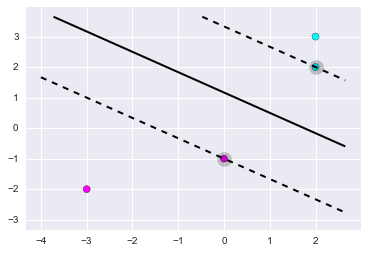

In [13]:
X = np.array([[2,2],[2,3],[0,-1], [-3, -2]])
Y = np.array([1, 1, -1, -1]).reshape((4,1))

svm = learner()
svm.set_data(X,Y)
svm.set_kernel_function(linear_kernel)
svm.make_kernel_matrix()
constraints = svm.train(1)

fig = plt.figure()
ax = fig.add_subplot(111)
plot_data(1, X, Y, (0), ax, '')

plt.gca().scatter(svm.support_vectors[:,0],
            svm.support_vectors[:,1], 
            s = 200,
            c = 'black',
            alpha = .2) # ugly but whatevs

plt.savefig('figs/toy.pdf')

In [4]:
for constraint in constraints:
    print constraint, constraints[constraint]

A [ 1.00e+00  1.00e+00 -1.00e+00 -1.00e+00]

b [ 0.00e+00]

G [ 1.00e+00  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]
[-1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00]

h [ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[-0.00e+00]
[-0.00e+00]
[-0.00e+00]
[-0.00e+00]

q [-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]

P [ 8.00e+00  1.00e+01  2.00e+00  1.00e+01]
[ 1.00e+01  1.30e+01  3.00e+00  1.20e+01]
[ 2.00e+00  3.00e+00  1.00e+00  2.00e+00]
[ 1.00e+01  1.20e+01  2.00e+00  1.30e+01]



# Linear Kernel for Each Data Set

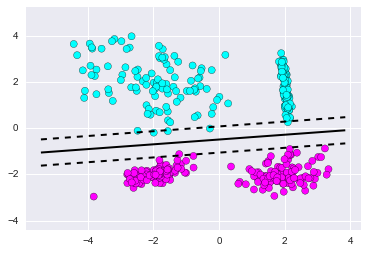

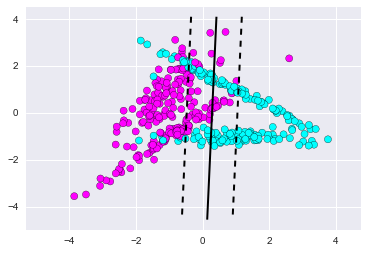

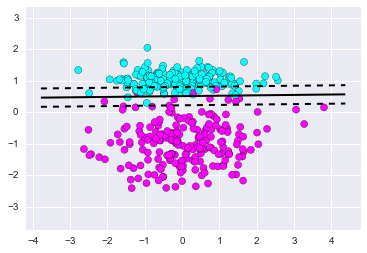

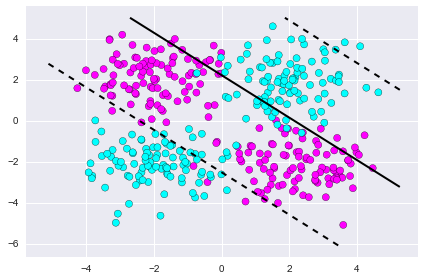

In [6]:
C = 1

table = pd.DataFrame({'Data Set' : [],
                      'Training Error': [],
                      'Validation Error': []})

for i in [1, 2, 3, 4]:

    X,Y = read_data(data_path(i, 'train'))

    svm = learner()
    svm.set_data(X,Y)
    svm.set_kernel_function(linear_kernel)
    svm.make_kernel_matrix()
    svm.train(C)
    
    X_val, Y_val = read_data(data_path(i, 'validate'))
    
    training_error = svm.training_error()
    validation_error = svm.test_error(X_val, Y_val)
    add_to_table = pd.DataFrame({'Data Set'        : [i],
                                 'Training Error'  : [training_error],
                                 'Validation Error': [validation_error]})
    table = table.append(add_to_table)
                      
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_data(i, X, Y, (0), ax, '')
    plt.savefig('figs/svm_linear_' + str(i) + '.pdf')
plt.tight_layout()

In [7]:
table

,Data Set,Training Error,Validation Error
0,1,0.000,0.0000
0,2,0.200,0.1750
0,3,0.015,0.0400
0,4,0.665,0.7025


# Gaussian Kernel: Messing with $C$

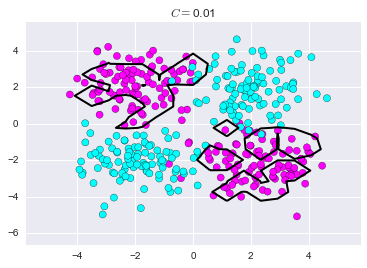

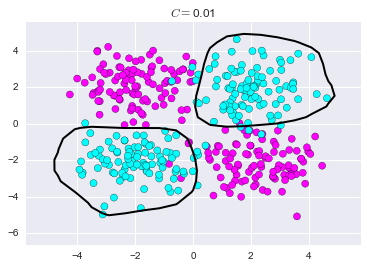

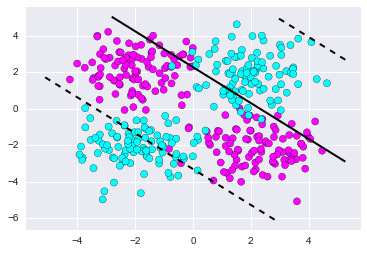

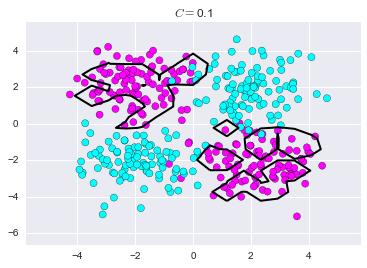

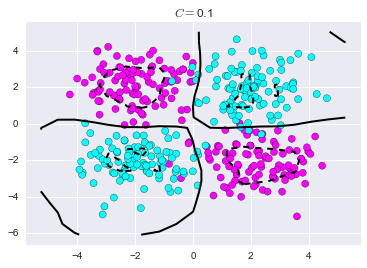

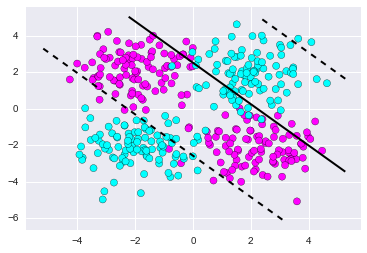

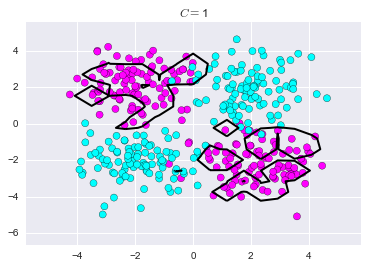

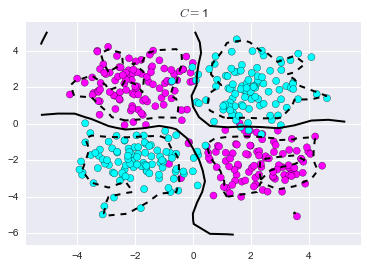

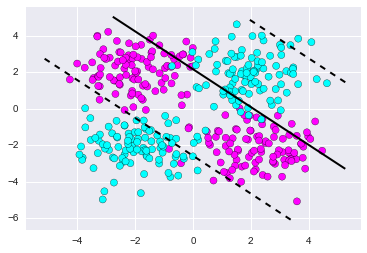

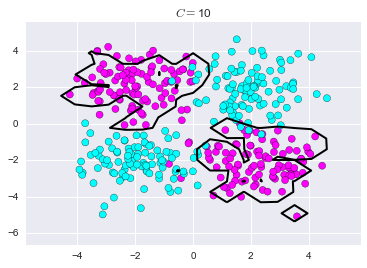

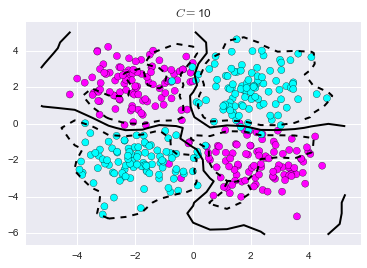

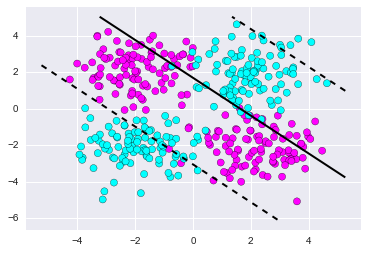

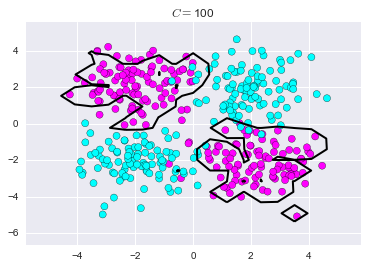

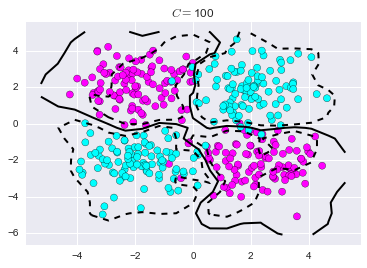

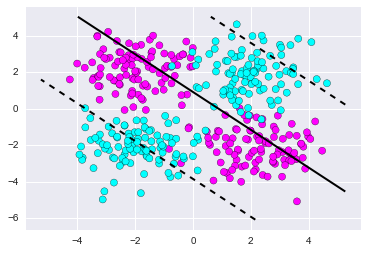

In [10]:
table = pd.DataFrame({'C' : [],
                      's' : [],
                      'Training Error': [],
                      'Validation Error': [],
                      'Margin': [],
                      'Support Vectors': []})

Cs = [10 ** p for p in [-2, -1, 0, 1, 2]]
ss = [0.1, 1]

i = 4
for j in range(len(Cs)):
    for s in ss: 
        X,Y = read_data(data_path(i, 'train'))
        svm = learner()
        svm.set_data(X,Y)
        
        # do the Gaussian one: 
        svm.set_kernel_function(lambda x, y: gaussian_kernel(x,y, s = s))
        svm.make_kernel_matrix()
        svm.train(Cs[j])

        X_val, Y_val = read_data(data_path(i, 'validate'))

        training_error = svm.training_error()
        validation_error = svm.test_error(X_val, Y_val)
        margin = svm.get_margin()
        n_supports = len(svm.get_supports())
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plot_data(j+1, X, Y, (0), ax, r'$C = $' + str(Cs[j]))
        plt.savefig('figs/svm_gaussian_C_' + str(Cs[j]) + '_s_' + str(s) + '.pdf')

        add_to_table = pd.DataFrame({'C' : [Cs[j]],
                                     's' : s,
                          'Training Error': [training_error],
                          'Validation Error': [validation_error],
                                    'Margin' : margin,
                                    'Support Vectors' : n_supports})
        table = table.append(add_to_table)
        
    # do the linear one: 
    svm.set_kernel_function(linear_kernel)
    svm.make_kernel_matrix()
    svm.train(Cs[j])

    X_val, Y_val = read_data(data_path(i, 'validate'))

    training_error = svm.training_error()
    validation_error = svm.test_error(X_val, Y_val)
    margin = svm.get_margin()
    n_supports = len(svm.get_supports())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_data(j+1, X, Y, (0), ax, '')
    plt.savefig('figs/svm_linear_C' + str(Cs[j]) + '_s' + str(s) + '.pdf')

    add_to_table = pd.DataFrame({'C' : [Cs[j]],
                                 's' : np.nan,
                      'Training Error': [training_error],
                      'Validation Error': [validation_error],
                                'Margin' : margin,
                                'Support Vectors' : n_supports})

    table = table.append(add_to_table)

In [9]:
table # summarize the results

,C,Margin,Support Vectors,Training Error,Validation Error,s
0,0.01,9.000174,400,0.0000,0.2550,0.1
0,0.01,9.000188,400,0.0475,0.0650,1.0
0,0.01,15.830624,399,0.6625,0.6950,NaN
0,0.10,0.090002,400,0.0000,0.2550,0.1
0,0.10,1.696500,267,0.0350,0.0525,1.0
0,0.10,11.341948,393,0.6675,0.6900,NaN
0,1.00,0.001769,398,0.0000,0.2625,0.1
0,1.00,0.078146,125,0.0325,0.0500,1.0
0,1.00,10.828198,392,0.6600,0.7025,NaN
0,10.00,0.001712,398,0.0000,0.2125,0.1
